# Using Bio-Signals to Predict Smoker Status

I chose the following dataset: https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

I decided on using this dataset because it provides over 55,000 rows of biological data, including bio-signals like the levels of individual hormones and proteins, about both smokers and non-smokers. I am interested in determining if there are any strong trends or clusters between any combination of these bio-signals and smoking.

This code installs two packages that are used for running hypothesis tests and doing posthoc analyses later in the document. It only needs to be run once.

In [3]:
!pip install pingouin
!pip install scikit_posthocs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 1.8 MB/s eta 0:00:00


This code imports all the necessary packages.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

pd.options.display.max_columns = None

This code loads in the train and test datasets, which were already split. However, this means that there is the possibility that there exist duplicate rows within and across the datasets, so the following code eliminates all duplicates. If a row is duplicated in the same dataset, then one copy is simply removed. If a row is duplicated between the train and test datasets, then the copy is removed from the train dataset.

In [5]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

na_train = train_df.isna().sum().sum()
na_test = test_df.isna().sum().sum()

print("Number of NaN values in train_df: ", na_train, "\nNumber of NaN values in test_df: ", na_test, "\n\n")

# Drop rows that are duplicated between the given train and test datasets

df_merge = pd.merge(train_df, test_df, how='inner')
merged = pd.concat([train_df, df_merge])

merged['Duplicated'] = merged.duplicated(subset=['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'], keep=False)
train_df = merged[~merged['Duplicated']]
del train_df['Duplicated']

features_lst = list(set(train_df.columns) - set(['smoking']))

train_df.info()
train_df.head()

Number of NaN values in train_df:  0 
Number of NaN values in test_df:  0 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28842 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  28842 non-null  int64  
 1   height(cm)           28842 non-null  int64  
 2   weight(kg)           28842 non-null  int64  
 3   waist(cm)            28842 non-null  float64
 4   eyesight(left)       28842 non-null  float64
 5   eyesight(right)      28842 non-null  float64
 6   hearing(left)        28842 non-null  int64  
 7   hearing(right)       28842 non-null  int64  
 8   systolic             28842 non-null  int64  
 9   relaxation           28842 non-null  int64  
 10  fasting blood sugar  28842 non-null  int64  
 11  Cholesterol          28842 non-null  int64  
 12  triglyceride         28842 non-null  int64  
 13  HDL                  28842 non-null  int64  
 14  LDL      

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,97,239,153,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,88,211,128,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,80,193,120,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,249,210,366,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,100,179,200,47,92,14.9,1,1.2,26,28,15,0,0


# Statistical Method #1
It must be determined whether the given train and test datasets have similar trends to each other. If the test dataset is not representative of the train dataset, any machine learning model would be evaluated on data with different trends than what it was trained with, resulting in the model having poorly trained hyperparameters, low precision and accuracy, and poor robustness.

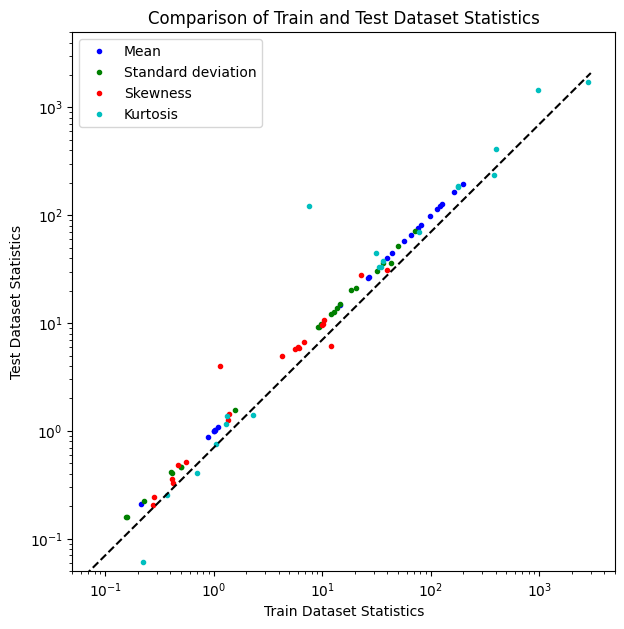

Pearson correlation coefficient:  0.9282975749371307


In [52]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='k')

plt.figure(figsize=(7, 7))

train_pts_lst = pd.concat([train_df[features_lst].mean(), train_df[features_lst].std(),
                          train_df[features_lst].skew(), train_df[features_lst].kurtosis()]).tolist()

test_pts_lst = pd.concat([test_df[features_lst].mean(), test_df[features_lst].std(),
                          test_df[features_lst].skew(), test_df[features_lst].kurtosis()]).tolist()

slope, intercept, r_value, p_value, std_err = stats.linregress(train_pts_lst, test_pts_lst)
# print(slope)

# print(type(train_df[features_lst].mean()))

plt.plot(train_df[features_lst].mean(), test_df[features_lst].mean(), 'b.', label='Mean')
plt.plot(train_df[features_lst].std(), test_df[features_lst].std(), 'g.', label='Standard deviation')
plt.plot(train_df[features_lst].skew(), test_df[features_lst].skew(), 'r.', label='Skewness')
plt.plot(train_df[features_lst].kurtosis(), test_df[features_lst].kurtosis(), 'c.', label='Kurtosis')

abline(slope, intercept)

# text = 'Pearson Correlation Coefficient: ' + str(r_value)
# plt.text(0, 0, text, fontsize = 2)

plt.title('Comparison of Train and Test Dataset Statistics')
plt.xlabel('Train Dataset Statistics')
plt.ylabel('Test Dataset Statistics')

plt.xlim(5e-2, 5e3)
plt.ylim(5e-2, 5e3)
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.show()

print('Pearson correlation coefficient: ', r_value)

Since the Pearson Correlation Coefficient is 0.928, there is a strong positive trend between the test and train data statistics. Therefore, the test dataset can be used to test the accuracy and efficacy of the machine learning model.

# Statistical Method #2
In order to see if a machine learning model can find trends in the biomarkers between smokers and non-smokers, there needs to exist some set of differences between the two groups for at least one characteristic. Here, the first step is feature engineering, adding four more characteristics, so that there are potentially more differences for a ML model to determine. These characteristics are easily calculated by doing basic mathematical operations on the original datasets, and have a broader meaning to the field of biology.

* BMI refers to the body mass index, which measures body fat based on height and weight.
* The Blood Pressure Difference refers to the difference between the Systolic and Relaxation Blood Pressures, which is the Pulse Pressure.
* The HDL-LDL ratio refers to HDL (high-density lipoprotein) cholesterol divided by LDL (low-density lipoprotein) cholesterol. This can be significant because research experiments have found [links](https://www.healthline.com/health/smoking-and-cholesterol#heart-attack-risk:~:text=lung%20cancer-,Beyond,-the%20impact%20on) between smoking, and lower HDL levels and higher LDL levels.
* The Liver Enzyme Ratio refers to the ratio between AST (Aspartate aminotransferase) and ALT (alanine aminotransferase). This ratio helps medical professionals diagnose liver injuries, and smoking is known to impact the liver.

In [7]:
def bmi(x):
  return x['weight(kg)'] / ((x['height(cm)'] / 100) ** 2)

def bp_diff(x):
  return x['systolic'] - x['relaxation']

def hdl_ldl_ratio(x):
  return x['HDL'] / x['LDL']

def liver_enzyme_ratio(x):
  return x['AST'] / x['ALT']

train_df['BMI'] = train_df.apply(lambda x : bmi(x), axis=1)
test_df['BMI'] = test_df.apply(lambda x : bmi(x), axis=1)

train_df['BP Diff'] = train_df.apply(lambda x : bp_diff(x), axis=1)
test_df['BP Diff'] = test_df.apply(lambda x : bp_diff(x), axis=1)

train_df['HDL-LDL Ratio'] = train_df.apply(lambda x : hdl_ldl_ratio(x), axis=1)
test_df['HDL-LDL Ratio'] = test_df.apply(lambda x : hdl_ldl_ratio(x), axis=1)

train_df['Liver Enzyme Ratio'] = train_df.apply(lambda x : liver_enzyme_ratio(x), axis=1)
test_df['Liver Enzyme Ratio'] = test_df.apply(lambda x : liver_enzyme_ratio(x), axis=1)

train_df.head()
test_df.head()

<ipython-input-7-4c84ab14bb6f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['BMI'] = train_df.apply(lambda x : bmi(x), axis=1)
<ipython-input-7-4c84ab14bb6f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['BP Diff'] = train_df.apply(lambda x : bp_diff(x), axis=1)
<ipython-input-7-4c84ab14bb6f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,BMI,BP Diff,HDL-LDL Ratio,Liver Enzyme Ratio
0,40,170,65,75.1,1.0,0.9,1,1,120,70,102,225,260,41,132,15.7,1,0.8,24,26,32,0,22.491349,50.0,0.310606,0.923077
1,45,170,75,89.0,0.7,1.2,1,1,100,67,96,258,345,49,140,15.7,1,1.1,26,28,138,0,25.951557,33.0,0.350000,0.928571
2,30,180,90,94.0,1.0,0.8,1,1,115,72,88,177,103,53,103,13.5,1,1.0,19,29,30,0,27.777778,43.0,0.514563,0.655172
3,60,170,50,73.0,0.5,0.7,1,1,118,78,86,187,70,65,108,14.1,1,1.3,31,28,33,0,17.301038,40.0,0.601852,1.107143
4,30,170,65,78.0,1.5,1.0,1,1,110,70,87,190,210,45,103,14.7,1,0.8,21,21,19,0,22.491349,40.0,0.436893,1.000000


Before performing the statistical tests, a violin plot of each characteristic, grouped by smoking status, is displayed to compare the distributions.

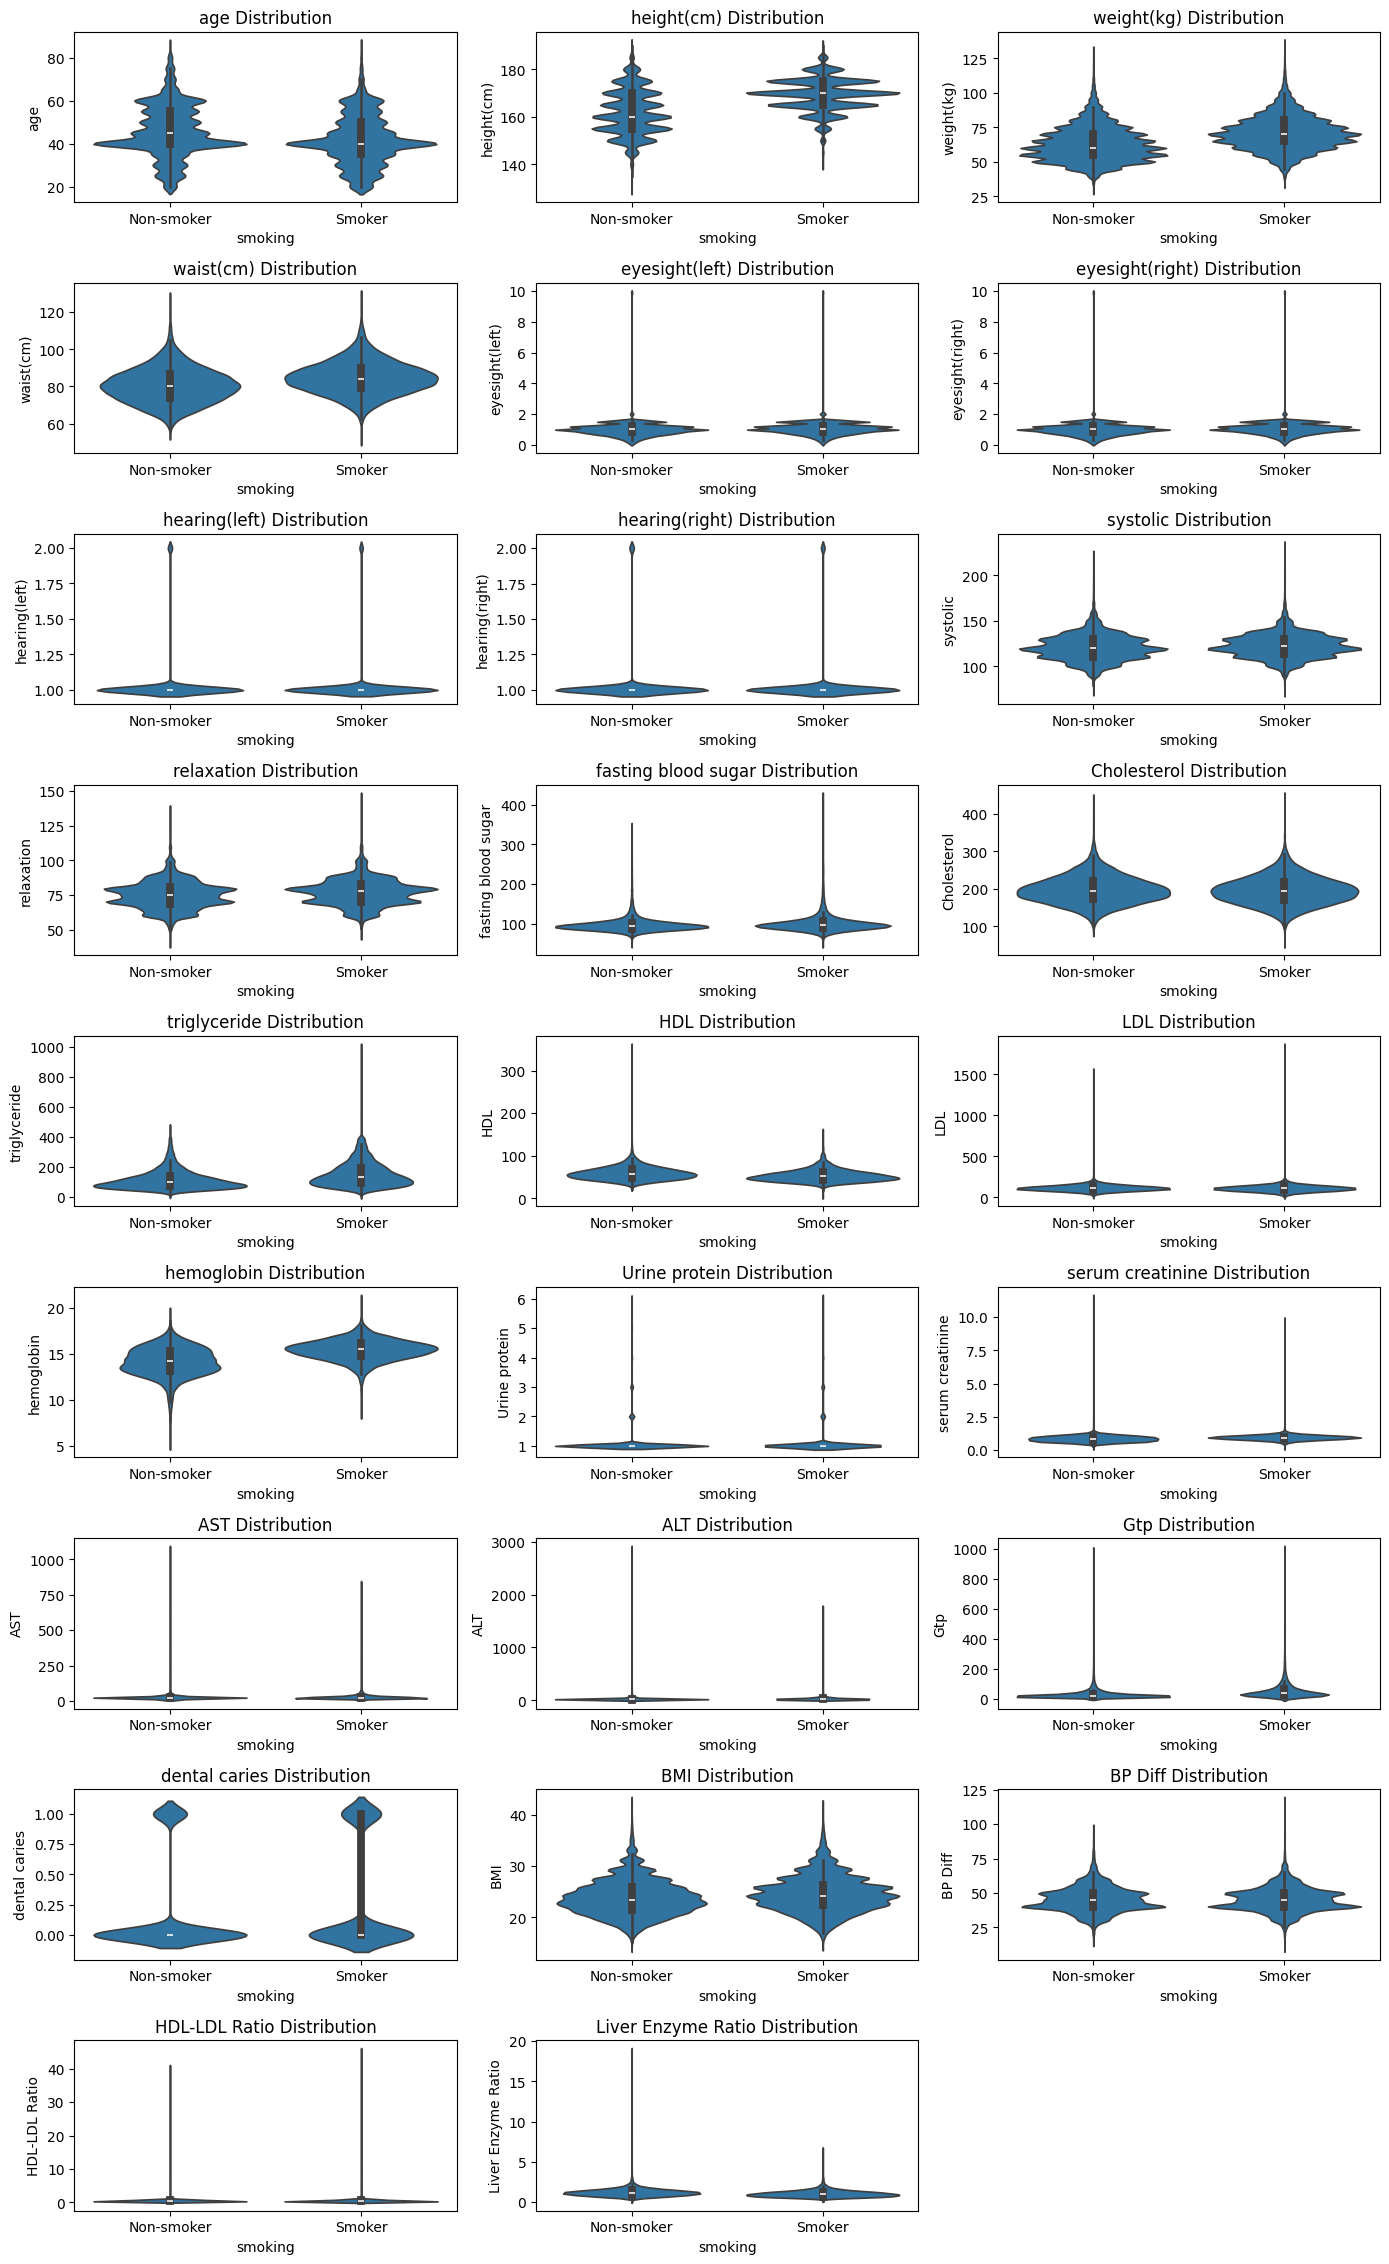

In [8]:
cols = train_df.columns.tolist()
cols.remove('smoking')

num_rows = len(cols)
num_cols = 3

total_plots = num_rows * num_cols
plt.figure(figsize=(14, num_rows * 2.5))

for idx, col in enumerate(cols):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(x=train_df['smoking'], y=col, data=train_df)
    plt.title(f"{col} Distribution")
    plt.xticks(ticks=[0, 1], labels=['Non-smoker', 'Smoker'])

plt.tight_layout()
plt.show()

There are some characteristics where there is visibly a difference in the distribution between smokers and non-smokers from the graphs, namely:
* Height
* Weight
* Waist size
* Triglycerides
* Hemoglobin

More formally, a two sample T Test can be conducted for each attribute to determine if the difference in means is significant. That is, for each characteristic:

* *H0*: the mean of the characteristic is the same between the group of non-smokers and smokers.

* *HA*: the mean of the characteristic is different between the group of non-smokers and smokers.

The following code conducts the hypothesis test for each characteristic and prints the resulting p values.

In [9]:
for idx, col in enumerate(cols):
  non_smokers = train_df[train_df['smoking'] == 0][col].tolist()
  smokers = train_df[train_df['smoking'] == 1][col].tolist()

  no_var = np.var(non_smokers)
  yes_var = np.var(smokers)

  if max(no_var, yes_var) / min(no_var, yes_var) <= 4:
    stat, p_val = stats.ttest_ind(a=non_smokers, b=smokers, equal_var=True)
    print('Column: ', col, "\t\t\tP value: ", p_val)
  else:
    stat, p_val = stats.ttest_ind(a=non_smokers, b=smokers, equal_var=False)
    print('Column: ', col, "\t\t\tP value: ", p_val)

Column:  age 			P value:  2.9748195937127138e-176
Column:  height(cm) 			P value:  0.0
Column:  weight(kg) 			P value:  0.0
Column:  waist(cm) 			P value:  0.0
Column:  eyesight(left) 			P value:  3.3145093896351197e-22
Column:  eyesight(right) 			P value:  1.030825638404225e-27
Column:  hearing(left) 			P value:  0.00021542870058488233
Column:  hearing(right) 			P value:  0.004243107412020721
Column:  systolic 			P value:  5.3389109236324125e-33
Column:  relaxation 			P value:  3.587665238757433e-67
Column:  fasting blood sugar 			P value:  3.228049183093769e-62
Column:  Cholesterol 			P value:  3.071497320925957e-07
Column:  triglyceride 			P value:  0.0
Column:  HDL 			P value:  1.657765571612189e-201
Column:  LDL 			P value:  1.0062022829857233e-11
Column:  hemoglobin 			P value:  0.0
Column:  Urine protein 			P value:  0.00857699251031957
Column:  serum creatinine 			P value:  1.9871670881199577e-260
Column:  AST 			P value:  4.732131756694557e-29
Column:  ALT 			P value:  5.53421

The value of $\alpha$ used in these hypothesis tests is 0.05. The p value for the two sample T Test is less than $\alpha$ for every characteristic apart from 'BP Diff', or the difference between the Systolic and Relaxation Blood Pressures. Therefore, there is a statistically significant difference between the means of each characteristic, apart from Blood Pressure Difference, when compared between non-smokers and smokers. This means that there exist many markers that the ML model can utilize to predict if a person is a smoker or non-smoker, based on solely biomarker data.

# Statistical Method #3
Another important thing to note is how each characteristic correlates to each other. So, correlation heatmaps are calculated for both the train and test datasets, and some non-obvious correlations are examined.

<Axes: >

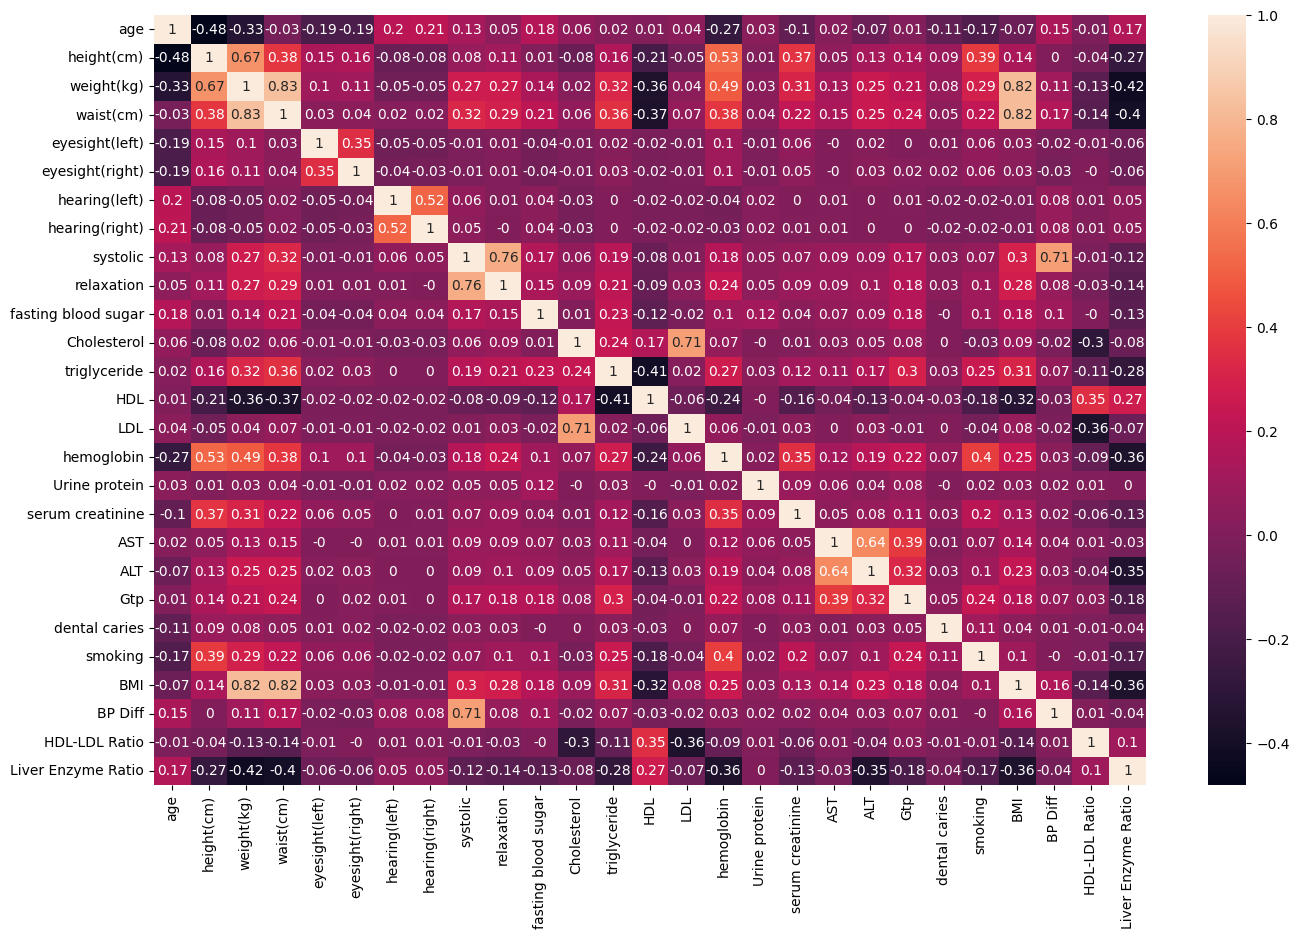

In [32]:
fig, ax = plt.subplots(figsize=(16,10))
train_corr = train_df.corr().round(2)
sns.heatmap(train_corr, annot=True, ax=ax)

There are some moderately strong correlations between two characteristics. Some of these are expected because the data points measure similar attributes of the person. Examples include the following:
* Height and Weight
* Left and right eyesight
* Left and right hearing
* Cholesterol and LDL (LDL is a type of cholesterol)
* AST and ALT (both are liver enzymes)

There are also some correlations that aren't immediately obvious, as such as those graphed below:


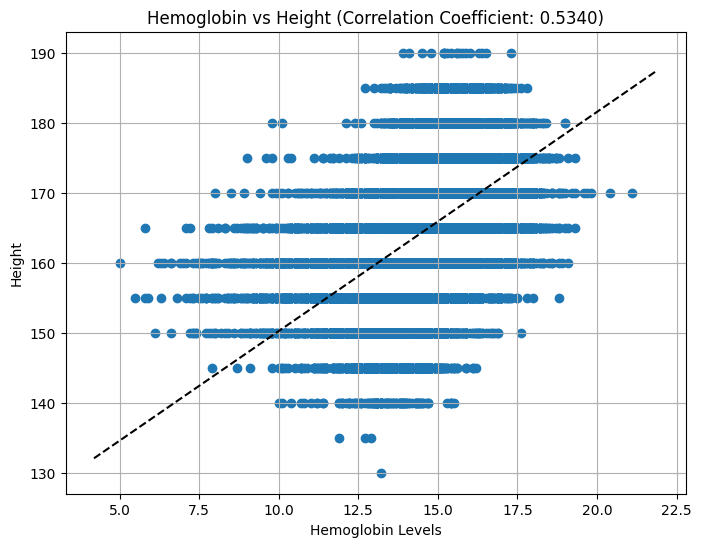

In [29]:
hemo_height_corr_coeff = train_df['hemoglobin'].corr(train_df['height(cm)'])

plt.figure(figsize=(8, 6))
plt.scatter(train_df['hemoglobin'], train_df['height(cm)'])
plt.xlabel('Hemoglobin Levels')
plt.ylabel('Height')
plt.title(f'Hemoglobin vs Height (Correlation Coefficient: {hemo_height_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['hemoglobin'].tolist(), train_df['height(cm)'].tolist())
abline(slope, intercept)

plt.show()

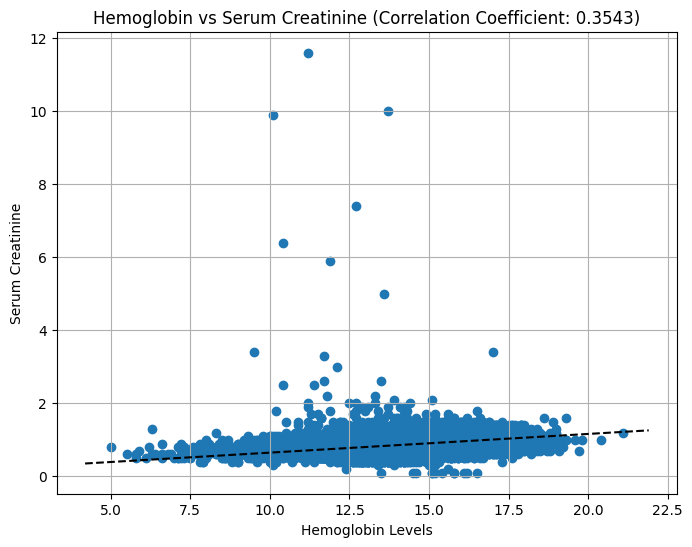

In [30]:
hemo_serum_corr_coeff = train_df['hemoglobin'].corr(train_df['serum creatinine'])

plt.figure(figsize=(8, 6))
plt.scatter(train_df['hemoglobin'], train_df['serum creatinine'])
plt.xlabel('Hemoglobin Levels')
plt.ylabel('Serum Creatinine')
plt.title(f'Hemoglobin vs Serum Creatinine (Correlation Coefficient: {hemo_serum_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['hemoglobin'].tolist(), train_df['serum creatinine'].tolist())
abline(slope, intercept)

plt.show()

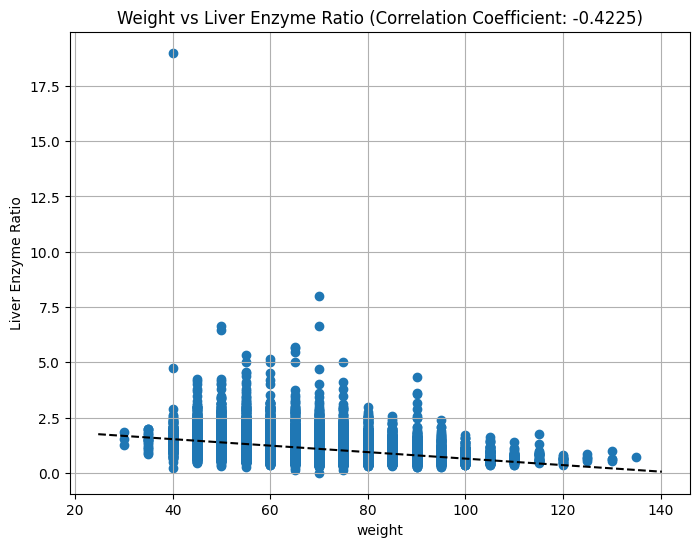

In [31]:
hemo_serum_corr_coeff = train_df['weight(kg)'].corr(train_df['Liver Enzyme Ratio'])

plt.figure(figsize=(8, 6))
plt.scatter(train_df['weight(kg)'], train_df['Liver Enzyme Ratio'])
plt.xlabel('weight')
plt.ylabel('Liver Enzyme Ratio')
plt.title(f'Weight vs Liver Enzyme Ratio (Correlation Coefficient: {hemo_serum_corr_coeff:.4f})')
plt.grid(True)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_df['weight(kg)'].tolist(), train_df['Liver Enzyme Ratio'].tolist())
abline(slope, intercept)

plt.show()

Clearly, there are a few moderately strong correlations between characteristics, but most characteristics don't overlap very much with each other.

The correlations on the test dataset can also be checked to further ensure that it is representative of the data in the train dataset.

<Axes: >

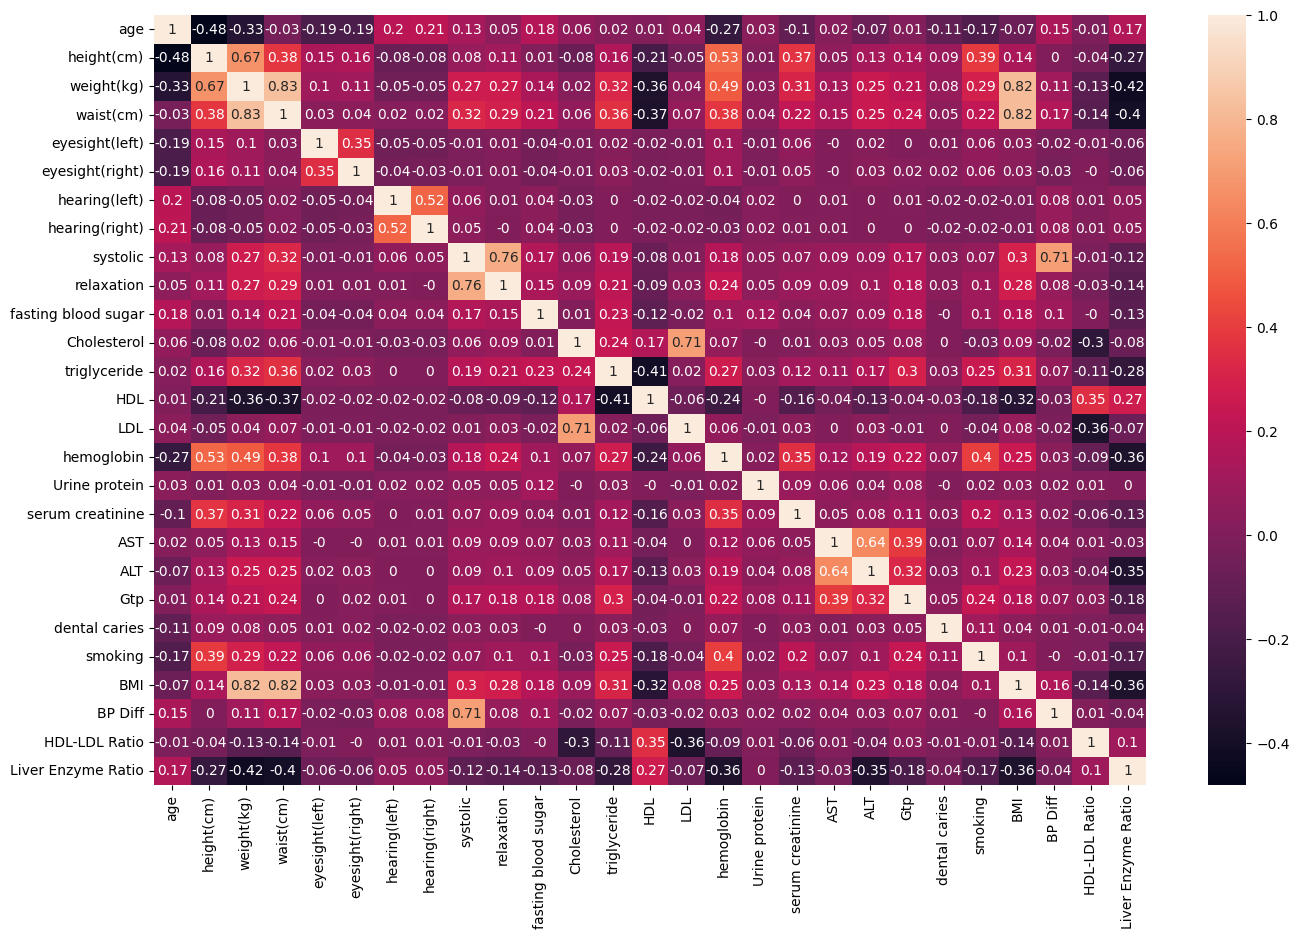

In [33]:
fig, ax = plt.subplots(figsize=(16,10))
test_corr = train_df.corr().round(2)
sns.heatmap(test_corr, annot=True, ax=ax)

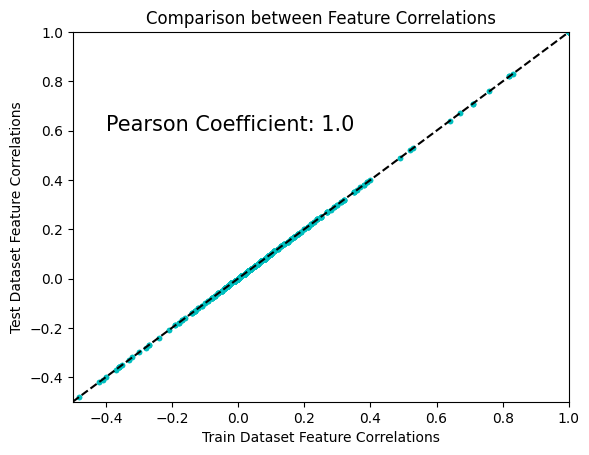

In [47]:
train_corr = np.array(train_corr).flatten()
test_corr = np.array(test_corr).flatten()

plt.plot(train_corr, test_corr, 'c.')
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)

slope, intercept, r_value, p_value, std_err = stats.linregress(train_corr, test_corr)
abline(slope, intercept)

text = 'Pearson Coefficient: ' + str(r_value)
plt.text(-.4, .6, text, fontsize = 15)

plt.xlabel('Train Dataset Feature Correlations')
plt.ylabel('Test Dataset Feature Correlations')

plt.title('Comparison between Feature Correlations')

plt.show()

Since the Pearson Correlation Coefficient of each correlation between the train and test dataset is 1.0, there is a perfect linear relationship between the correlations. This further supports the statement that the test dataset represents the same trends as the train dataset.